In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging
import numpy as np

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from cross_defPlot import *
from cross_compute import *

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', protocol = 'tcp://',
                      host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35245 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:35245/status,
Dashboard: http://137.129.155.67:35245/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:35599,Workers: 1
Dashboard: http://137.129.155.67:35245/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:46205,Total threads: 4
Dashboard: http://137.129.155.67:38417/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
wave_OLR = ['OLR_TD', 'OLR_MJO', 'OLR_Kelvin', 'OLR_Rossby', 'OLR_MRG', 'OLR_EIG','OLR_WIG']
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'
coeff = 1

ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 10})
# ds = ds.assign_coords(lon = (((ds.lon + 180) % 360) - 180)).sortby('lon')

indir_var = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/ANOMALY_FILTERED/'
season = 'YEAR'
ds_var = xr.open_mfdataset(indir_var + 'OLR_' + season + '.nc')
ds_std = ds_var**(0.5)
ds_std

spd = 8
day = 3
min_periode = day * spd 

# OLR

### On ne garde que les données au-dessus ou en-dessous de l'ecart type, qu'on appelle phase active de l'onde ou phase non-active.
La phase active permet de savoir si l'onde contribue à la diminution de l'anomalie pour l'OLR. La phase non active à son augmentation. 
### On sépare en trois chaque phase active ou non active.
En phase croissante, décroissante et maximum

In [3]:
### Compute of gradient
for w in wave_OLR:
    ds = addNegative(ds, ds_std, w)
ds

<xarray.Dataset>
Dimensions:           (time: 52592, lat: 60, lon: 360)
Coordinates:
  * time              (time) datetime64[ns] 2001-01-01 ... 2018-12-31T21:00:00
  * lat               (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 27.5 28.5 29.5
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables: (12/21)
    OLR_Kelvin        (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    OLR_Rossby        (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    OLR_MJO           (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    OLR_MRG           (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    OLR_EIG           (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    OLR_WIG           (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    ...                ...
    STD_OLR_MRG       (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_MRG_N     (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_EIG       (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_EIG_N     (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_WIG       (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>
    STD_OLR_WIG_N     (time, lat, lon) float64 dask.array<chunksize=(10, 60, 360), meta=np.ndarray>

In [4]:
def keepData(ds, coeff, wave_REF):
    _ds = ds
    _ds[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds[wave_REF], np.nan)
    return _ds

def keepData_GRAD(ds, ds_GRAD, coeff, wave_REF):
    _ds_GRAD = ds_GRAD
    _ds_GRAD[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds_GRAD[wave_REF], np.nan)
    return ds_GRAD

In [5]:
coeff = 1
for w in wave_OLR:
    ds_keep = keepData(ds, coeff, w)
    
    
# ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXAFRIQUE/mean_OLR_TCWV_wave.nc')


In [36]:
ds_FILTER_keep = ds.sel(lat = 0, lon = 5, method = 'nearest')
ds_FILTER_keep = ds_FILTER_keep.sel(time = slice('2009-03-01','2009-04-01')).compute()


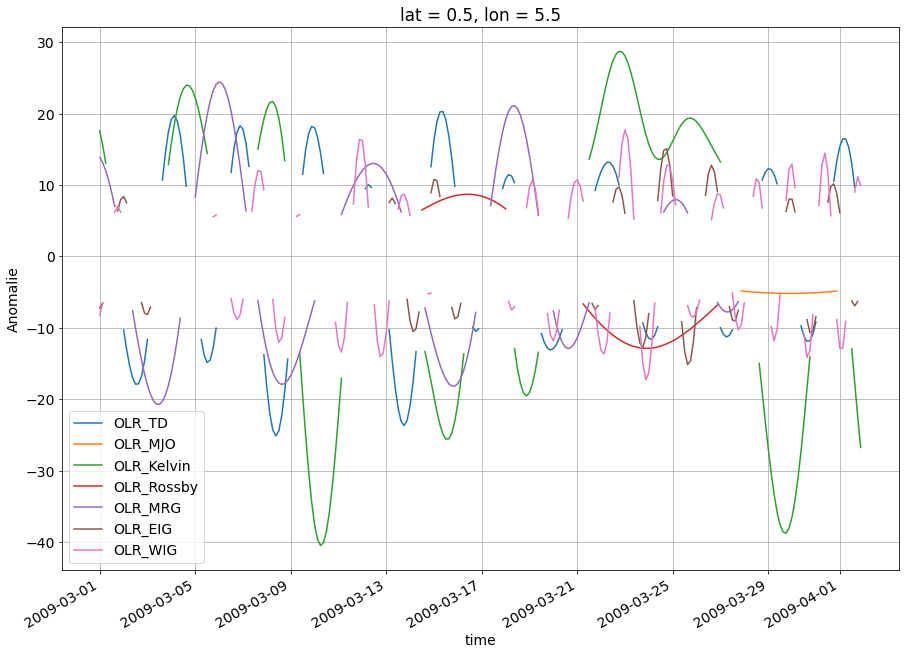

In [37]:
plt.figure(figsize = (15,10))
for w in wave_OLR :
    ds_FILTER_keep[w].plot(label = w)
# ds_FILTER_keep['OLR_ano'].sel(time = slice('2009-09-15','2009-10-01')).plot(label = 'anomalie')
plt.grid()
plt.ylabel('Anomalie')
plt.legend()
plt.show()



In [10]:
ds_keep_Kelvin = ds_keep['OLR_Kelvin'].sel(lat = slice(0,15)).compute()
ds_keep_Rossby = ds_keep['OLR_Rossby'].sel(lat = slice(5,20)).compute()

In [75]:
_ds_keep_Kelvin

<xarray.DataArray 'OLR_Kelvin' (time: 52592, lon: 360)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ..., -13.19036476,
        -12.44682292,          nan],
       [         nan,          nan,          nan, ..., -13.36969326,
        -12.70864557,          nan],
       [         nan,          nan,          nan, ..., -13.39882343,
        -12.85222819, -12.19204719]])
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2018-12-31T21:00:00
    lat      float32 0.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

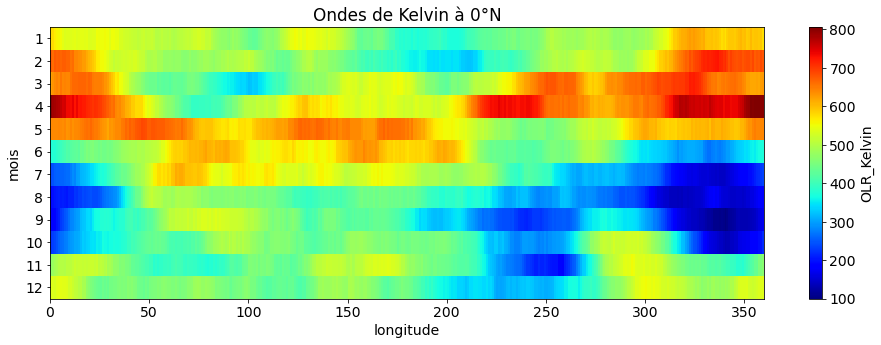

In [78]:
_ds_keep_Kelvin = ds_keep_Kelvin.sel(time = slice('2001-12-01','2014-12-01'), lat = 0.5).copy()
_ds_keep_Kelvin = xr.where(_ds_keep_Kelvin > 0, np.nan, _ds_keep_Kelvin)
ds_nb_jour = _ds_keep_Kelvin.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0 + 1
ds_sel_jour = _ds_keep_Kelvin.copy() * 0.

# for m in range(ds_keep_Kelvin.time.size):
#     if m%100 == 0:
#         print(m , 'on ', ds_keep_Kelvin.time.size)
# #     for l in range(ds_keep_Kelvin.lon.size):
#     dd = _ds_keep_Kelvin.isel(time = m)
# #         if dd<0:
# #             ds_nb_jour[m,l] = 1
ds_nb_jour = ds_nb_jour.where(_ds_keep_Kelvin<0, 0,drop= False)

data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Kelvin à 0°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

0
36
72
108
144
180
216
252
288
324


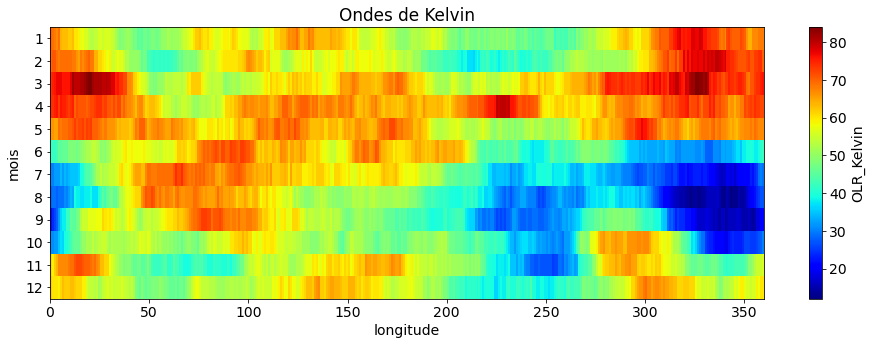

In [48]:
from scipy.signal import find_peaks

_ds_keep_Kelvin = ds_keep_Kelvin.sel(lat = 0, method = 'nearest').copy()
_ds_keep_Kelvin = xr.where(_ds_keep_Kelvin > 0, np.nan, _ds_keep_Kelvin)
ds_nb_jour = _ds_keep_Kelvin.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0
ds_sel_jour = _ds_keep_Kelvin.copy() * 0.

for l in range(ds_keep_Kelvin.lon.size):
    if l%36 == 0:
        print(l)
    numpy_data = _ds_keep_Kelvin.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = min_periode-4)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        ds_sel_jour[m,l] = _ds_keep_Kelvin.isel(time = m, lon = l)
        
data_plot = ds_nb_jour.groupby('time.month').sum()


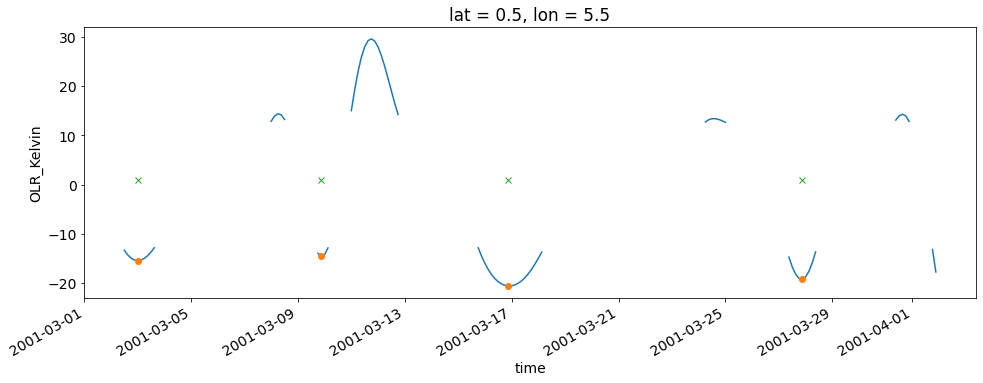

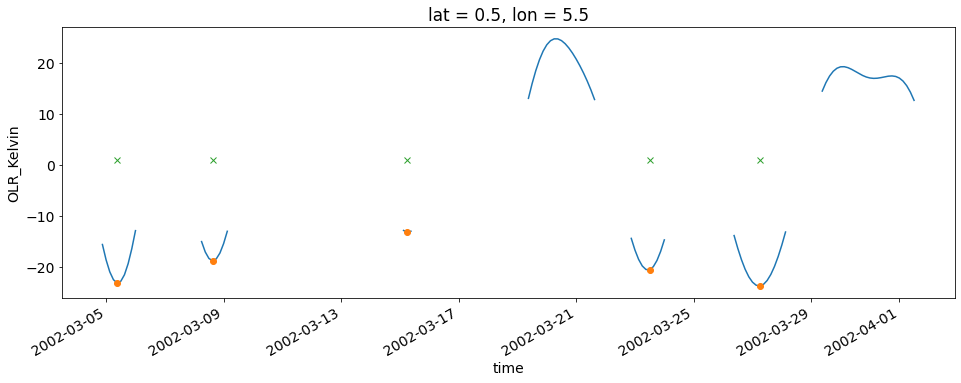

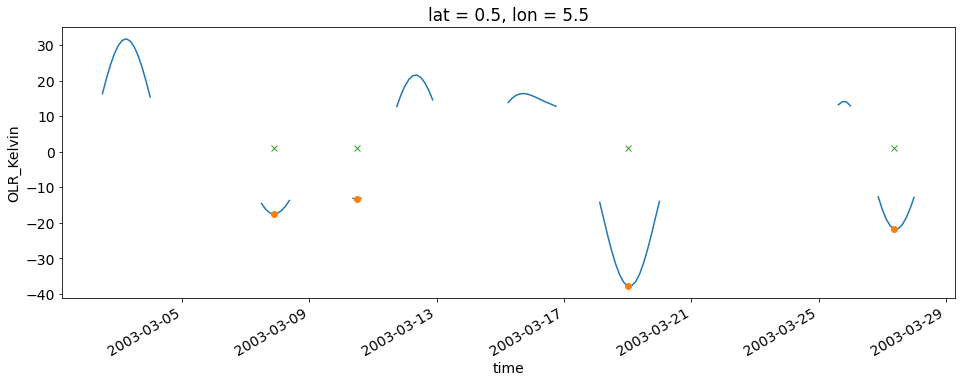

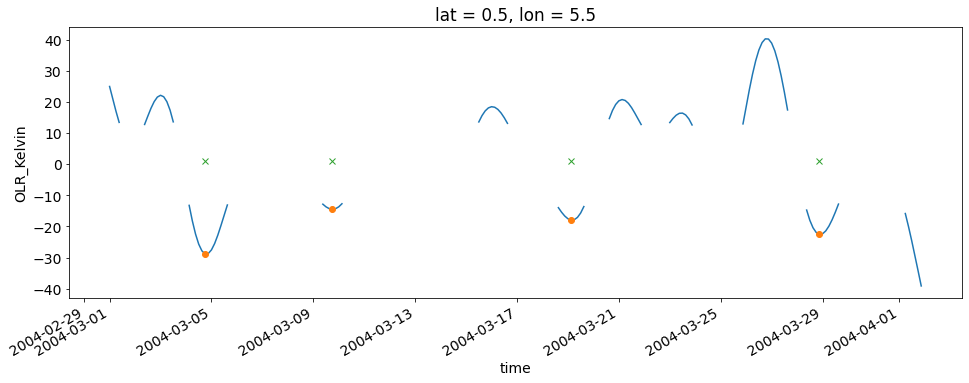

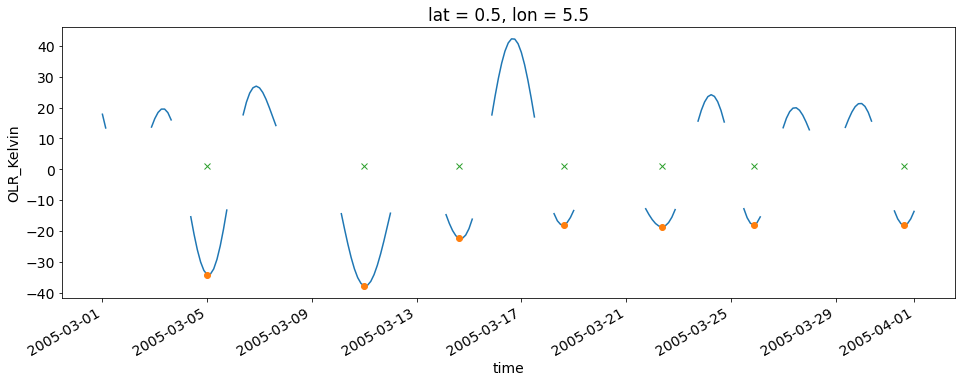

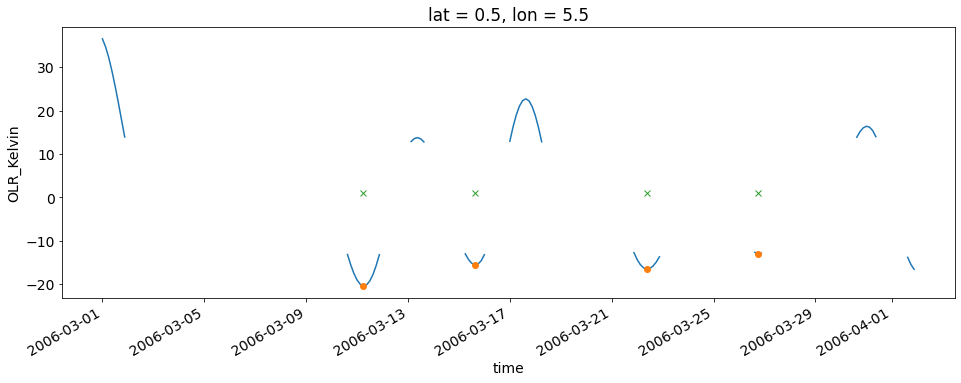

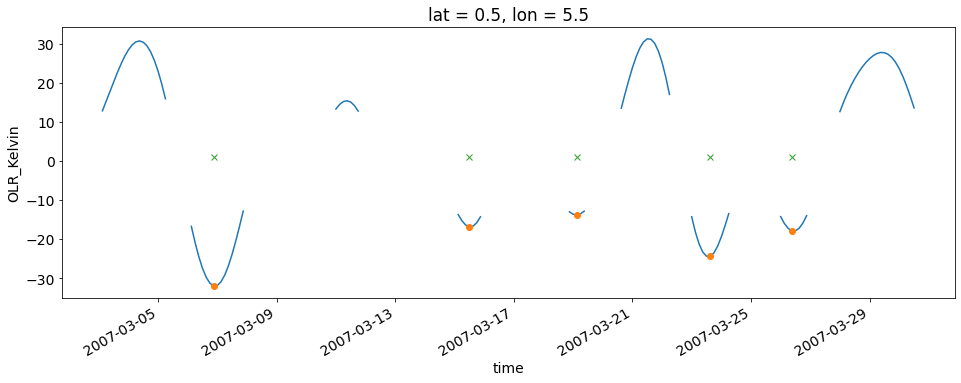

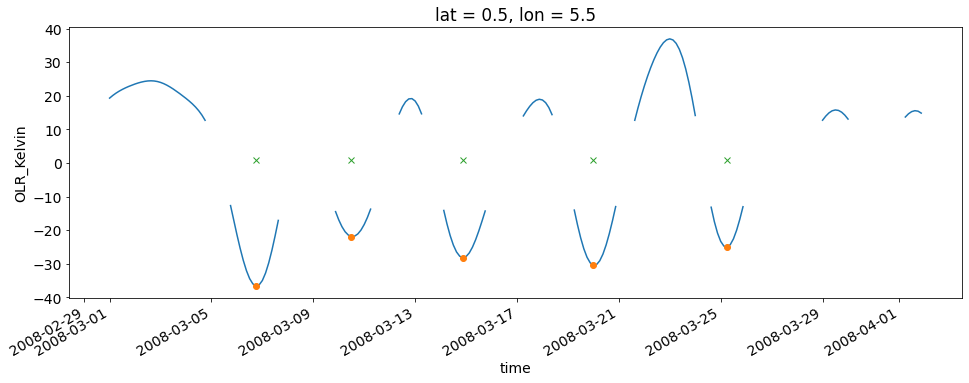

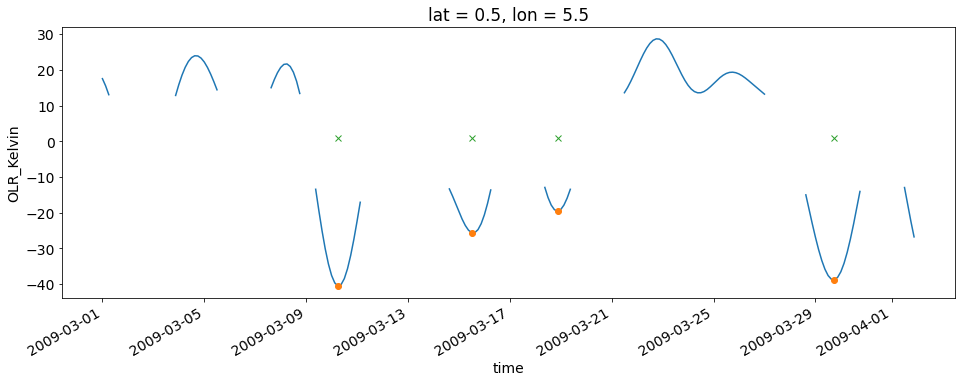

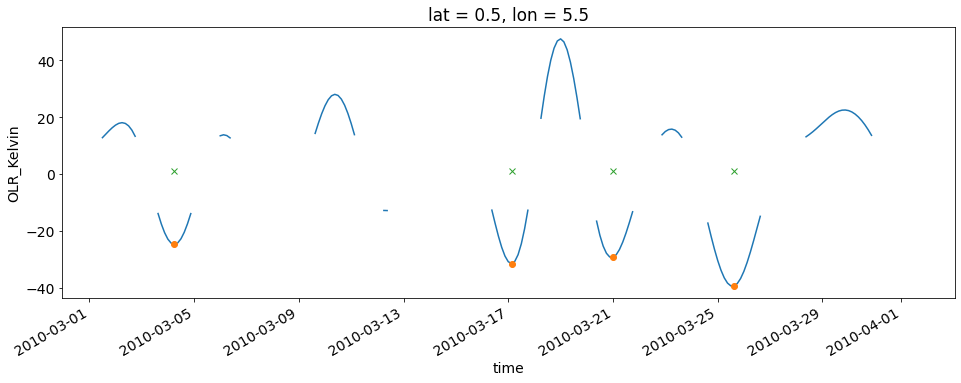

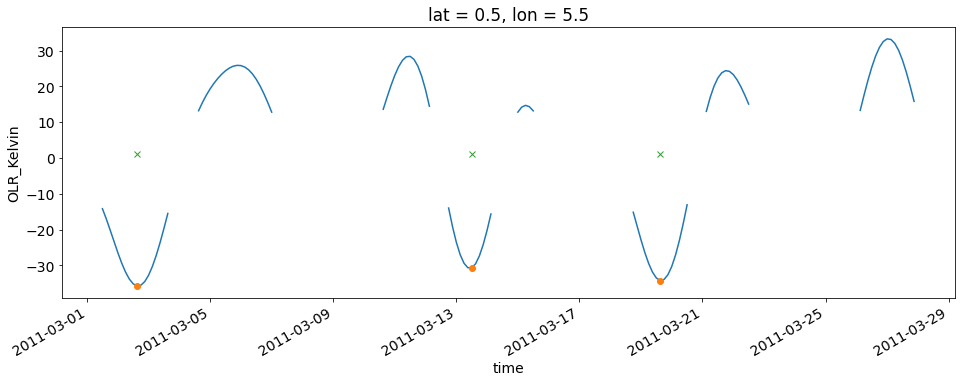

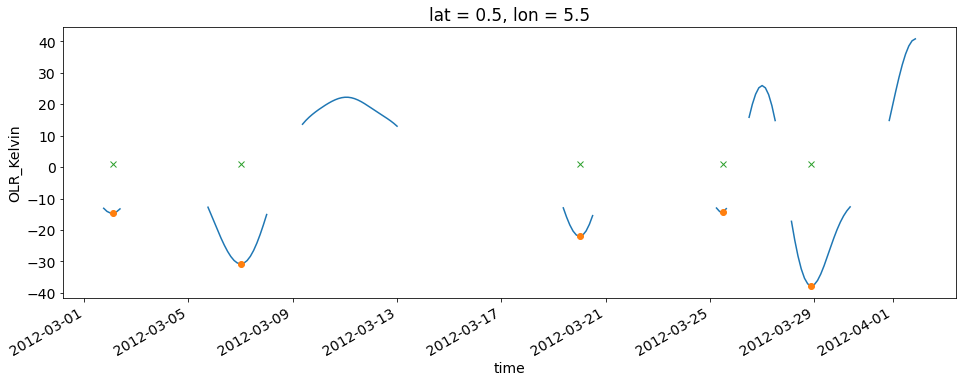

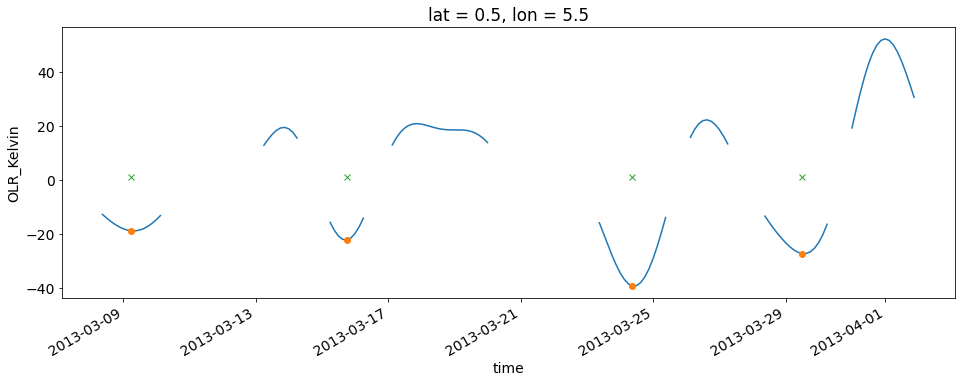

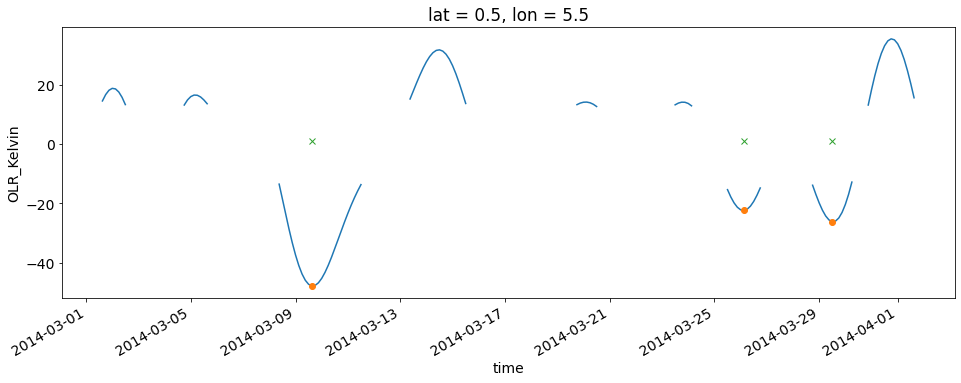

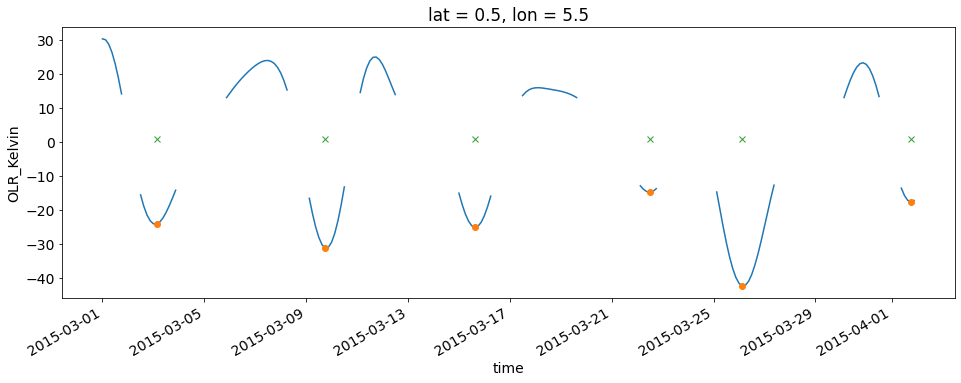

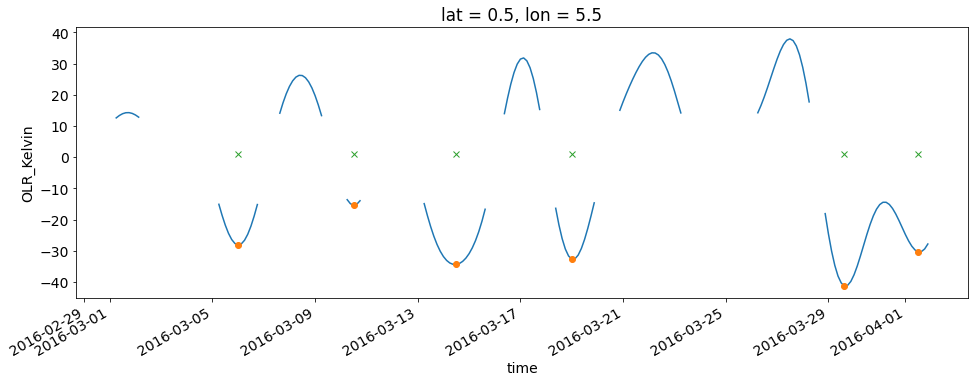

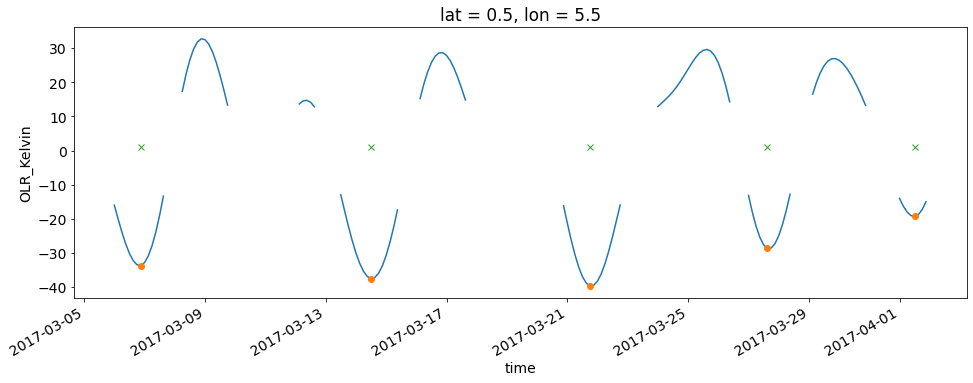

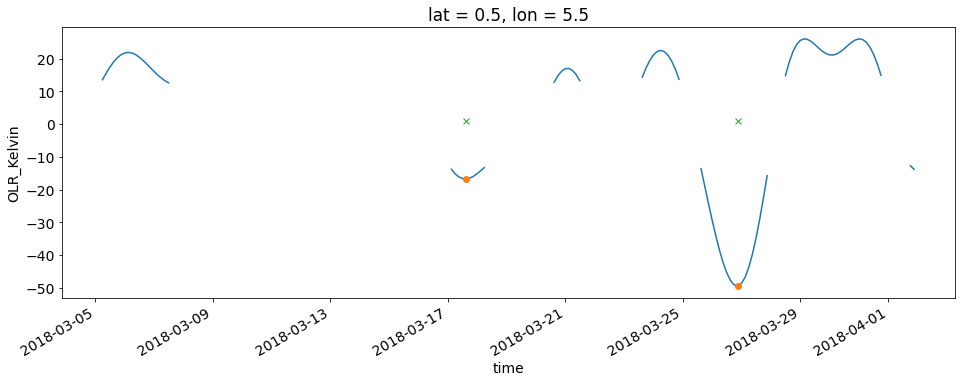

In [49]:
ds_nb_jour.isel(lon = 10).sum(dim = 'time')

for y in range(2001,2019):
    
    ds_FILTER_keep = ds_keep_Kelvin.sel(lat = 0, lon = 5, method = 'nearest')
    ds_FILTER_keep = ds_FILTER_keep.sel(time = slice(str(y)+'-03-01',str(y)+'-04-01'))
    _ds_sel_jour = ds_sel_jour.sel(lon = 5, method = 'nearest')
    _ds_sel_jour = _ds_sel_jour.sel(time = slice(str(y)+'-03-01',str(y)+'-04-01'))
    _ds_sel_jour = xr.where(_ds_sel_jour == 0, np.nan, _ds_sel_jour)
    _ds_nb_jour = ds_nb_jour.sel(lon = 5, method = 'nearest')
    _ds_nb_jour = _ds_nb_jour.sel(time = slice(str(y)+'-03-01',str(y)+'-04-01'))
    _ds_nb_jour = xr.where(_ds_nb_jour == 0, np.nan, 1)

    plt.figure()
    ds_FILTER_keep.plot()
    _ds_sel_jour.plot(marker="o")
    _ds_nb_jour.plot(marker="x")
    plt.show()

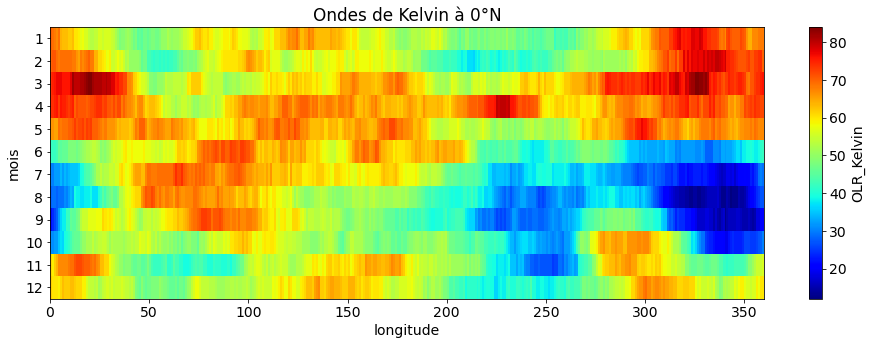

In [51]:

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Kelvin à 0°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

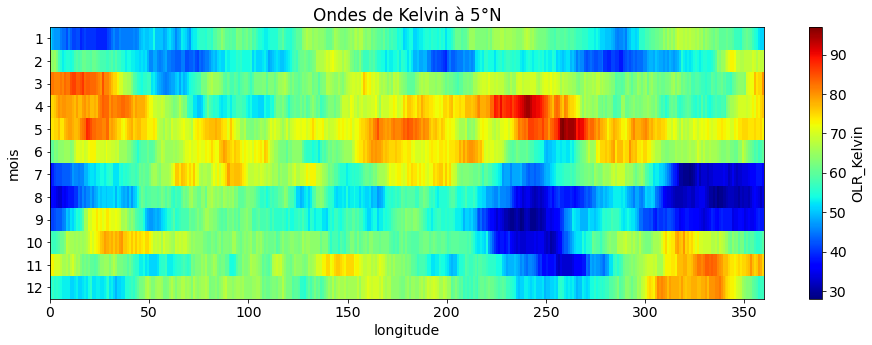

In [58]:
_ds_keep_Kelvin = ds_keep_Kelvin.sel(lat = 5, method = 'nearest')
ds_nb_jour = _ds_keep_Kelvin.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0

for l in range(ds_keep_Kelvin.lon.size):
#     print(l , ' on ', ds_keep_Kelvin.lon.size)
    numpy_data = _ds_keep_Kelvin.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Kelvin à 5°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

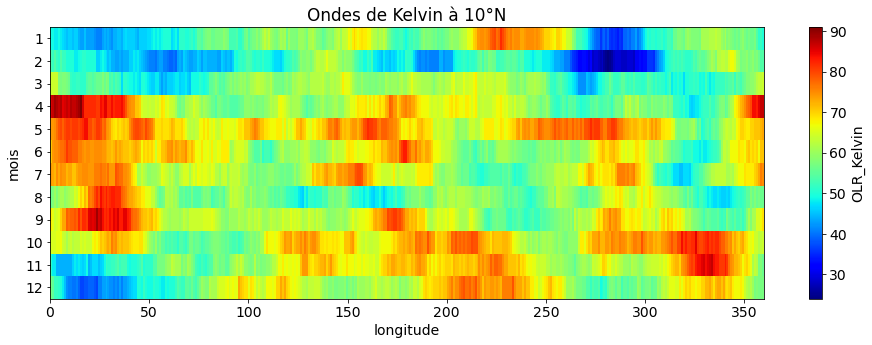

In [59]:
_ds_keep_Kelvin = ds_keep_Kelvin.sel(lat = 10, method = 'nearest')
ds_nb_jour = _ds_keep_Kelvin.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0

for l in range(ds_keep_Kelvin.lon.size):
#     print(l , ' on ', ds_keep_Kelvin.lon.size)
    numpy_data = _ds_keep_Kelvin.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Kelvin à 10°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

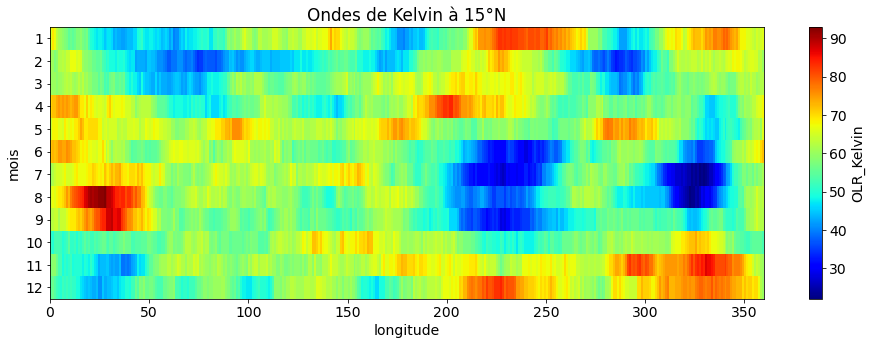

In [57]:
_ds_keep_Kelvin = ds_keep_Kelvin.sel(lat = 15, method = 'nearest')
ds_nb_jour = _ds_keep_Kelvin.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0

for l in range(ds_keep_Kelvin.lon.size):
#     print(l , ' on ', ds_keep_Kelvin.lon.size)
    numpy_data = _ds_keep_Kelvin.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Kelvin à 15°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

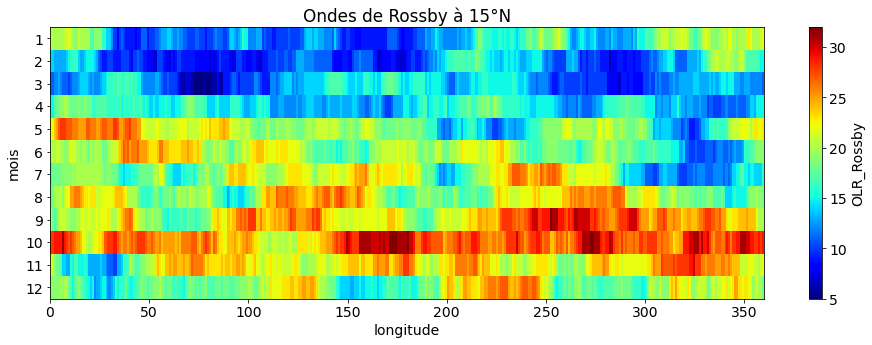

In [60]:
_ds_keep_Rossby = ds_keep_Rossby.sel(lat = 15, method = 'nearest')
ds_nb_jour = _ds_keep_Rossby.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0
# ds_nb_jour.groupby('time.month').mean()
ds_nb_jour

for l in range(ds_keep_Kelvin.lon.size):
#     print(l , ' on ', ds_keep_Rossby.lon.size)
    numpy_data = _ds_keep_Rossby.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Rossby à 15°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

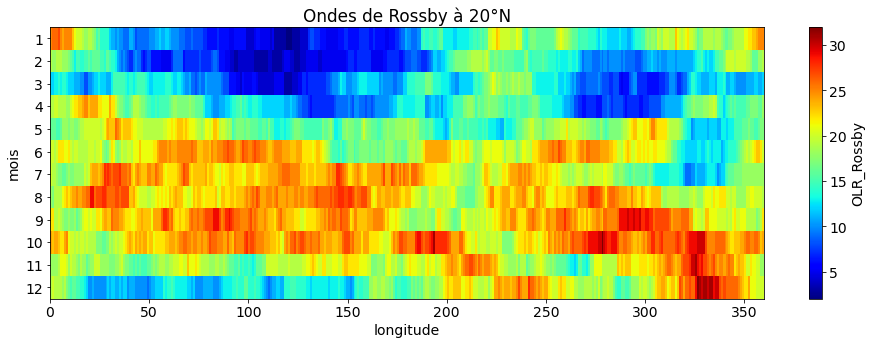

In [61]:
_ds_keep_Rossby = ds_keep_Rossby.sel(lat = 20, method = 'nearest')
ds_nb_jour = _ds_keep_Rossby.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0
# ds_nb_jour.groupby('time.month').mean()
ds_nb_jour

for l in range(ds_keep_Kelvin.lon.size):
#     print(l , ' on ', ds_keep_Rossby.lon.size)
    numpy_data = _ds_keep_Rossby.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 10)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Rossby à 20°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

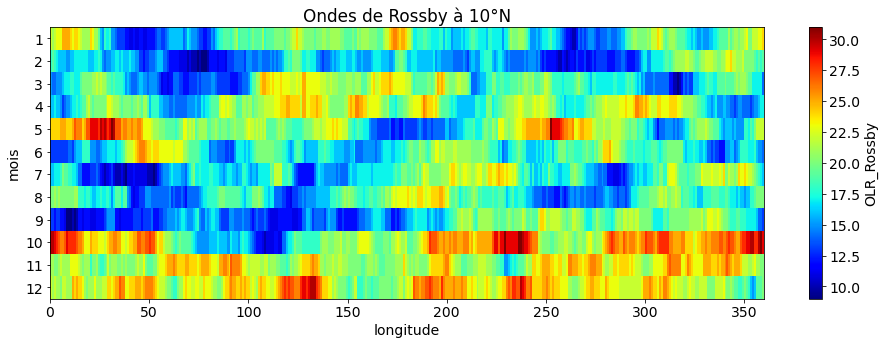

In [62]:
_ds_keep_Rossby = ds_keep_Rossby.sel(lat = 10, method = 'nearest')
ds_nb_jour = _ds_keep_Rossby.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0
# ds_nb_jour.groupby('time.month').mean()
ds_nb_jour

for l in range(ds_keep_Kelvin.lon.size):
#     print(l , ' on ', ds_keep_Rossby.lon.size)
    numpy_data = _ds_keep_Rossby.isel(lon = l)
    maxm, _ = find_peaks(numpy_data*-1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('Ondes de Rossby à 10°N')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()